# Fitting curves to real data

## Overview

When you have a real dataset, the easiest way to fit it is via the
`neutcurve.curvefits.CurveFits` class, which
streamlines the fitting and plotting of a set of
`neutcurve.hillcurve.HillCurve` neutralization curves.
Here we demonstrate how to do this.

## Importing Python packages

First, import the necessary Python modules. In addition to the
`neutcurve` package itself, we also use
[pandas](https://pandas.pydata.org/) to hold the data:

In [1]:
import pandas as pd

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

Set some pandas display options:

In [2]:
pd.set_option("display.float_format", "{:.3g}".format)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 500)

## Preparing the data

Now we get example data to fit. We use as our example the neutralization
of variants A/WSN/1933 (H1N1) influenza by the broadly neutralizing
antibody FI6v3 and strain-specific antibody H17-L19 from [Fig 6a,b of
Doud et al
(2018)](https://www.nature.com/articles/s41467-018-03665-3#Fig6).
We start by reading these data into a pandas DataFrame:

In [3]:
fi6v3_datafile = "Doud_et_al_2018-neutdata.csv"

In [4]:
data = pd.read_csv(fi6v3_datafile)

# drop replicate 2 for one serum as this helps with some plot testing below
data = data[(data["serum"] != "H17-L19") | (data["replicate"] != 2)]

Here are the first few lines of the data frame:

In [5]:
data.head()

,serum,virus,replicate,concentration,fraction infectivity
0,FI6v3,WT,1,0.000205,1.01
1,FI6v3,WT,1,0.000478,0.942
2,FI6v3,WT,1,0.00112,0.993
3,FI6v3,WT,1,0.0026,0.966
4,FI6v3,WT,1,0.00607,0.957


And here are the last few lines:

In [6]:
data.tail()

,serum,virus,replicate,concentration,fraction infectivity
427,H17-L19,V135T,3,0.386,1.02
428,H17-L19,V135T,3,0.9,1
429,H17-L19,V135T,3,2.1,0.959
430,H17-L19,V135T,3,4.9,0.991
431,H17-L19,V135T,3,11.4,0.747


As can be seen above, the data are organized into five columns, all of
which must be present. These columns are:

 * *serum*: the name of the
   serum (or antibody). FI6v3 and H17-L19 are actually antibodies, not
   sera, but `neutcurve.curvefits.CurveFits` is set up to refer to
   things as serum.

 * *virus*: the name of the virus being neutralized by
   the serum.

 * *replicate*: the replicate label for the measurement.
   Although you can have just one replicate, it’s good experimental
   practice to have several. All the replicates for a given virus / serum
   combination must have been measured at the same concentrations.

 * *concentration*: the concentration of the serum.

 * *fraction infectivity*: the fraction infectivity of the virus at this
   concentration of the serum measured in this replicate.

Note that the data are in [tidy form](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html);
you must make your data frame tidy before you can analyze it with
`neutcurve.curvefits.CurveFits`.

## Fitting the curves

Once you have the tidy data frame, it’s easy to pass it to
`neutcurve.curvefits.CurveFits`. We expect all of these
antibodies to go to complete neutralization when they are effective, so
we use default values of  and  argument (see
`neutcurve.hillcurve.HillCurves` and Hill-curve neutralization for more details about the
 and  options):

In [7]:
fits = neutcurve.CurveFits(data)

Now we can look at the different sera for which we have fit curves:

In [8]:
fits.sera

['FI6v3', 'H17-L19']

We can also look at the viruses measured against each serum:

In [9]:
for serum in fits.sera:
    print(f"Viruses measured against {serum}:\n" + str(fits.viruses[serum]))

Viruses measured against FI6v3:
['WT', 'K(-8T)', 'P80D', 'V135T', 'K280A', 'K280S', 'K280T', 'N291S', 'M17L-HA2', 'G47R-HA2']
Viruses measured against H17-L19:
['WT', 'V135T']


We can also look at the replicates for each serum and virus. Here we
just do that for serum *FI6v3* and virus *WT*. See how in addition to
the three replicates we have passed, there is also now an “average”
replicate that is automatically computed from the average of the other
replicates:

In [10]:
fits.replicates[("FI6v3", "WT")]

['1', '2', '3', 'average']

## Looking at a specific curve

We can use the `neutcurve.curvefits.CurveFits.getCurve()` method
to get the `neutcurve.hillcurve.HillCurve` that was fit for a
particular serum / virus / replicate combination. For instance, here we
do that for *serum* FI6v3 versus *virus* WT for replicate *1*. We then
plot the curve and print the IC50:

The IC50 is 0.0167


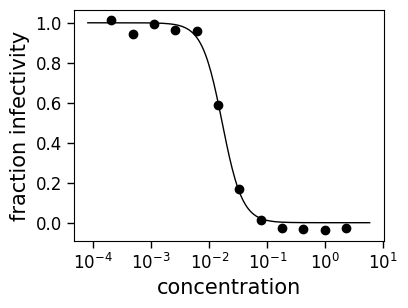

In [11]:
curve = fits.getCurve(serum="FI6v3", virus="WT", replicate="1")
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

`neutcurve.curvefits.CurveFits` also calculates the average and
standard error of the measurements for each serum / virus, and fits them
under a replicate name of “average”. Here is the fit to the average of
the data for *serum* FI6v3 and *virus* WT. Note how the plot now also
shows error bars indicating the standard error:

The IC50 is 0.017


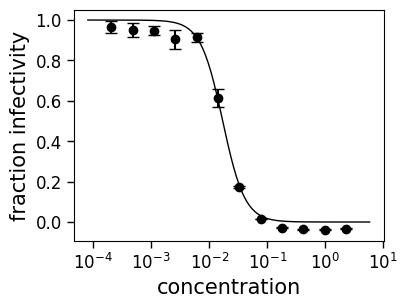

In [12]:
curve = fits.getCurve(serum="FI6v3", virus="WT", replicate="average")
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

## Accessing the fit parameters for all curves

You can get the fit parameters for the curves using
`neutcurve.curvefits.CurveFits.fitParams()`. By default, this just
gets the fits for the average of the replicates. The parameters are all
of those fit by a `neutcurve.hillcurve.HillCurve`, plus the
IC50 in several forms to accurately represent interpolated IC50s (IC50
within range of data) versus IC50s where we can just get the bound from
the upper or lower limits of the data:

In [13]:
fits.fitParams()

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2
0,FI6v3,WT,average,3,0.017,interpolated,0.017,0.017,0.017,interpolated,2.28,1,0,0.992
1,FI6v3,K(-8T),average,3,0.0283,interpolated,0.0283,0.0283,0.0283,interpolated,2.4,1,0,0.986
2,FI6v3,P80D,average,3,0.0123,interpolated,0.0123,0.0123,0.0123,interpolated,2.05,1,0,0.99
3,FI6v3,V135T,average,3,0.0229,interpolated,0.0229,0.0229,0.0229,interpolated,1.83,1,0,0.995
4,FI6v3,K280A,average,3,0.0106,interpolated,0.0106,0.0106,0.0106,interpolated,1.86,1,0,0.981
5,FI6v3,K280S,average,3,0.0428,interpolated,0.0428,0.0428,0.0428,interpolated,2,1,0,0.993
6,FI6v3,K280T,average,3,0.0348,interpolated,0.0348,0.0348,0.0348,interpolated,1.82,1,0,0.993
7,FI6v3,N291S,average,3,0.0845,interpolated,0.0845,0.0845,0.0845,interpolated,1.8,1,0,0.997
8,FI6v3,M17L-HA2,average,3,0.0198,interpolated,0.0198,0.0198,0.0198,interpolated,2.06,1,0,0.989
9,FI6v3,G47R-HA2,average,3,0.0348,interpolated,0.0348,0.0348,0.0348,interpolated,2.6,1,0,0.982


Looking above, you can see how the IC50 is handled depending on if it is
interpolated (in the range of concentrations used in the experiments)
versus outside the range of concentrations. In the table above, all of
the IC50s are interpolated **except** the last row (H17-L19 versus
V135T), which is just provided as an upper bound equal to the highest
concentration used in the experiment (the actual IC50 is greater than
this upper bound). We do **not** attempt to extrapolate IC50s outside
the data range as this is unreliable.

You can see there is also a column ("r2") that reports the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) as a measure of how well the curve fits the data.

Note that by default, `neutcurve.curvefits.CurveFits.fitParams()`
only returns the fitted params for the averages, as in the above table.
If you want to also return them for individual replicates, using
 argument `average_only=False`. Here we do this, showing only the first
few entries in the returned data frame; now there are now values for
each replicate as well as the average of replicates:

In [14]:
fits.fitParams(average_only=False).head()

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2
0,FI6v3,WT,1,<NA>,0.0167,interpolated,0.0167,0.0167,0.0167,interpolated,2.5,1,0,0.996
1,FI6v3,WT,2,<NA>,0.019,interpolated,0.019,0.019,0.019,interpolated,2.51,1,0,0.986
2,FI6v3,WT,3,<NA>,0.0152,interpolated,0.0152,0.0152,0.0152,interpolated,1.88,1,0,0.982
3,FI6v3,WT,average,3,0.017,interpolated,0.017,0.017,0.017,interpolated,2.28,1,0,0.992
4,FI6v3,K(-8T),1,<NA>,0.0308,interpolated,0.0308,0.0308,0.0308,interpolated,2.62,1,0,0.977


The “average” is the curve fit to the average of the data points, not the average of the fit parameters for individual curves.

You can also use `no_average` to not show the average:

In [15]:
fits.fitParams(average_only=False, no_average=True).head()

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2
0,FI6v3,WT,1,<NA>,0.0167,interpolated,0.0167,0.0167,0.0167,interpolated,2.5,1,0,0.996
1,FI6v3,WT,2,<NA>,0.019,interpolated,0.019,0.019,0.019,interpolated,2.51,1,0,0.986
2,FI6v3,WT,3,<NA>,0.0152,interpolated,0.0152,0.0152,0.0152,interpolated,1.88,1,0,0.982
3,FI6v3,K(-8T),1,<NA>,0.0308,interpolated,0.0308,0.0308,0.0308,interpolated,2.62,1,0,0.977
4,FI6v3,K(-8T),2,<NA>,0.0284,interpolated,0.0284,0.0284,0.0284,interpolated,2.55,1,0,0.986


We can also include arbitrary inhibitory concentrations, such as the IC95 in addition to the IC50 via the  argument to`neutcurve.curvefits.CurveFits.fitParams()`.
For instance:

In [16]:
fits.fitParams(ics=[50, 95])

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic95,ic95_bound,ic95_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2
0,FI6v3,WT,average,3,0.017,interpolated,0.017,0.062,interpolated,0.062,0.017,0.017,interpolated,2.28,1,0,0.992
1,FI6v3,K(-8T),average,3,0.0283,interpolated,0.0283,0.0967,interpolated,0.0967,0.0283,0.0283,interpolated,2.4,1,0,0.986
2,FI6v3,P80D,average,3,0.0123,interpolated,0.0123,0.0516,interpolated,0.0516,0.0123,0.0123,interpolated,2.05,1,0,0.99
3,FI6v3,V135T,average,3,0.0229,interpolated,0.0229,0.114,interpolated,0.114,0.0229,0.0229,interpolated,1.83,1,0,0.995
4,FI6v3,K280A,average,3,0.0106,interpolated,0.0106,0.0516,interpolated,0.0516,0.0106,0.0106,interpolated,1.86,1,0,0.981
5,FI6v3,K280S,average,3,0.0428,interpolated,0.0428,0.186,interpolated,0.186,0.0428,0.0428,interpolated,2,1,0,0.993
6,FI6v3,K280T,average,3,0.0348,interpolated,0.0348,0.176,interpolated,0.176,0.0348,0.0348,interpolated,1.82,1,0,0.993
7,FI6v3,N291S,average,3,0.0845,interpolated,0.0845,0.433,interpolated,0.433,0.0845,0.0845,interpolated,1.8,1,0,0.997
8,FI6v3,M17L-HA2,average,3,0.0198,interpolated,0.0198,0.083,interpolated,0.083,0.0198,0.0198,interpolated,2.06,1,0,0.989
9,FI6v3,G47R-HA2,average,3,0.0348,interpolated,0.0348,0.108,interpolated,0.108,0.0348,0.0348,interpolated,2.6,1,0,0.982


Include standard deviations on IC50s calculated from estimated errors on parameters during fitting.
Note that although this method is implemented, we **strongly** recommend instead fitting each replicate separately and computing errors that way instead (see immediately below):

In [17]:
fits.fitParams(ic50_error="fit_stdev")

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic50_error,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2
0,FI6v3,WT,average,3,0.017,interpolated,0.017,0.0254,0.017,0.017,interpolated,2.28,1,0,0.992
1,FI6v3,K(-8T),average,3,0.0283,interpolated,0.0283,0.0411,0.0283,0.0283,interpolated,2.4,1,0,0.986
2,FI6v3,P80D,average,3,0.0123,interpolated,0.0123,0.0193,0.0123,0.0123,interpolated,2.05,1,0,0.99
3,FI6v3,V135T,average,3,0.0229,interpolated,0.0229,0.0382,0.0229,0.0229,interpolated,1.83,1,0,0.995
4,FI6v3,K280A,average,3,0.0106,interpolated,0.0106,0.0176,0.0106,0.0106,interpolated,1.86,1,0,0.981
5,FI6v3,K280S,average,3,0.0428,interpolated,0.0428,0.0683,0.0428,0.0428,interpolated,2,1,0,0.993
6,FI6v3,K280T,average,3,0.0348,interpolated,0.0348,0.0582,0.0348,0.0348,interpolated,1.82,1,0,0.993
7,FI6v3,N291S,average,3,0.0845,interpolated,0.0845,0.142,0.0845,0.0845,interpolated,1.8,1,0,0.997
8,FI6v3,M17L-HA2,average,3,0.0198,interpolated,0.0198,0.0313,0.0198,0.0198,interpolated,2.06,1,0,0.989
9,FI6v3,G47R-HA2,average,3,0.0348,interpolated,0.0348,0.0477,0.0348,0.0348,interpolated,2.6,1,0,0.982


Here is the recommended way to get error estimates by just taking the average of fits for each replicate:

In [18]:
params_avg_fit = fits.fitParams()[
    ["serum", "virus", "ic50", "ic50_bound", "nreplicates"]
]
params_avg_reps = (
    fits.fitParams(average_only=False)
    .query('replicate != "average"')
    .groupby(["serum", "virus"])
    .aggregate(
        ic50_replicate_avg=pd.NamedAgg("ic50", "mean"),
        ic50_replicate_stderr=pd.NamedAgg("ic50", "sem"),
    )
    .reset_index()
)
params_avg_fit.merge(params_avg_reps, on=["serum", "virus"])

,serum,virus,ic50,ic50_bound,nreplicates,ic50_replicate_avg,ic50_replicate_stderr
0,FI6v3,WT,0.017,interpolated,3,0.017,0.00112
1,FI6v3,K(-8T),0.0283,interpolated,3,0.0283,0.0015
2,FI6v3,P80D,0.0123,interpolated,3,0.0123,0.000271
3,FI6v3,V135T,0.0229,interpolated,3,0.0229,0.000201
4,FI6v3,K280A,0.0106,interpolated,3,0.0106,0.000819
5,FI6v3,K280S,0.0428,interpolated,3,0.0428,0.000821
6,FI6v3,K280T,0.0348,interpolated,3,0.0349,0.00155
7,FI6v3,N291S,0.0845,interpolated,3,0.0844,0.00448
8,FI6v3,M17L-HA2,0.0198,interpolated,3,0.0197,0.000986
9,FI6v3,G47R-HA2,0.0348,interpolated,3,0.0347,0.000766


## Plotting the curves

One of the most useful feature of
`neutcurve.curvefits.CurveFits` are that they have methods to
easily generate multi-panel plots of the curves.

### Plotting each serum against multiple viruses

Often you will have measured each serum against several different viral
variants. You can then plot these curves using
`neutcurve.curvefits.CurveFits.plotSera()` as below:

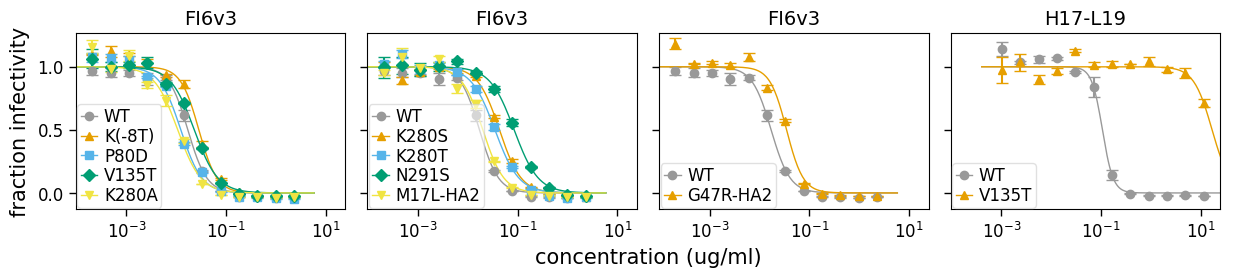

In [19]:
fig, axes = fits.plotSera(xlabel="concentration (ug/ml)")

The above plot attempts to put all the viruses measured against each
serum on the same subplot, but is cognizant of the fact that it becomes
uninterpretable if there are too many viruses on the same plot.
Therefore, it only shows a maximum of  (which
by default is 5) curves per subplot.

In fact, that is still perhaps too many curves per plot for this data set. So we can
customize the plot by adjusting that parameter. Below we adjust to just
four viruses per subplot, and also use  to specify that we
want two columns:

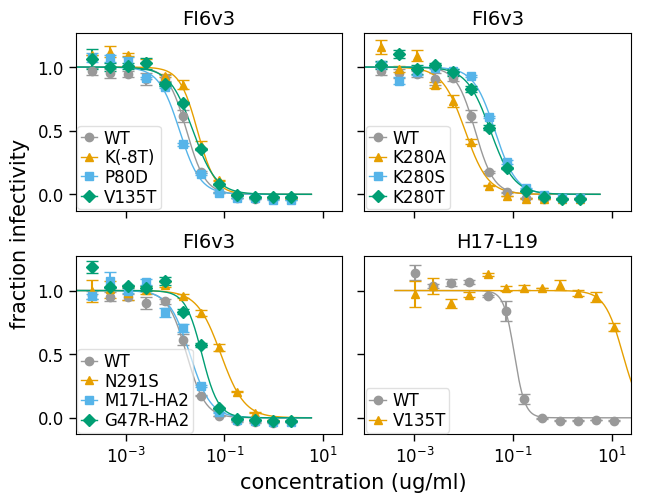

In [20]:
fig, axes = fits.plotSera(
    max_viruses_per_subplot=4, ncol=2, xlabel="concentration (ug/ml)"
)

The above plots all have a different legend for each subplot. This is
necessary because the number of different viruses being plotted exceeds
the numbers of colors / markers specified to
`neutcurve.curvefits.CurveFits.plotSera()` via its  and
 arguments, so there aren’t enough colors / markers to give
each virus a unique one.

However, if we reduce the number of viruses we are showing, we then get
a nice shared legend. Here we do this, using the  argument to
specify that we just show some of the viruses:

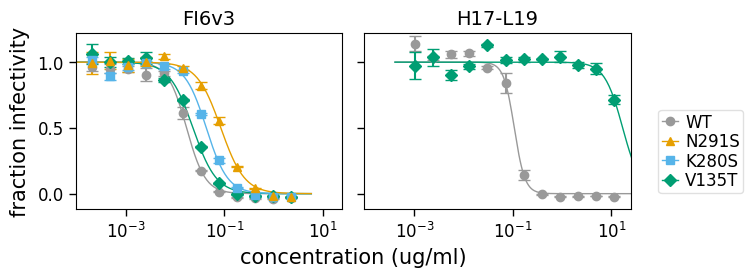

In [21]:
fig, axes = fits.plotSera(
    viruses=["WT", "N291S", "K280S", "V135T"], xlabel="concentration (ug/ml)"
)

Similar to how the above plot uses the  argument to plot just
some viruses, we can also use the  argument to plot just some of
the sera (in this case, just H17-L19):

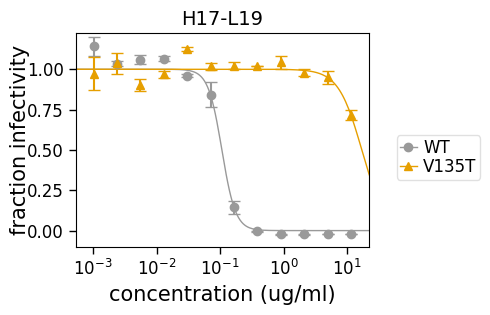

In [22]:
fig, axes = fits.plotSera(sera=["H17-L19"], xlabel="concentration (ug/ml)")

We can also use the  argument to specify a particular
color scheme:

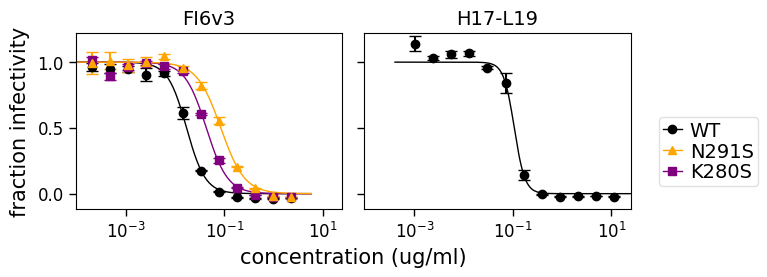

In [23]:
fig, axes = fits.plotSera(
    viruses=["WT", "N291S", "K280S"],
    xlabel="concentration (ug/ml)",
    virus_to_color_marker={
        "WT": ("black", "o"),
        "N291S": ("orange", "^"),
        "K280S": ("purple", "s"),
    },
    legendfontsize=14,
)

There are various additional options to
`neutcurve.curvefits.CurveFits.plotSera()` that can further
fine-tune the plots; see the docstring for that method for more details.

### Plotting each virus against multiple sera

It is also possible to plot each virus against multiple sera using
`neutcurve.curvefits.CurveFits.plotViruses()` as below:

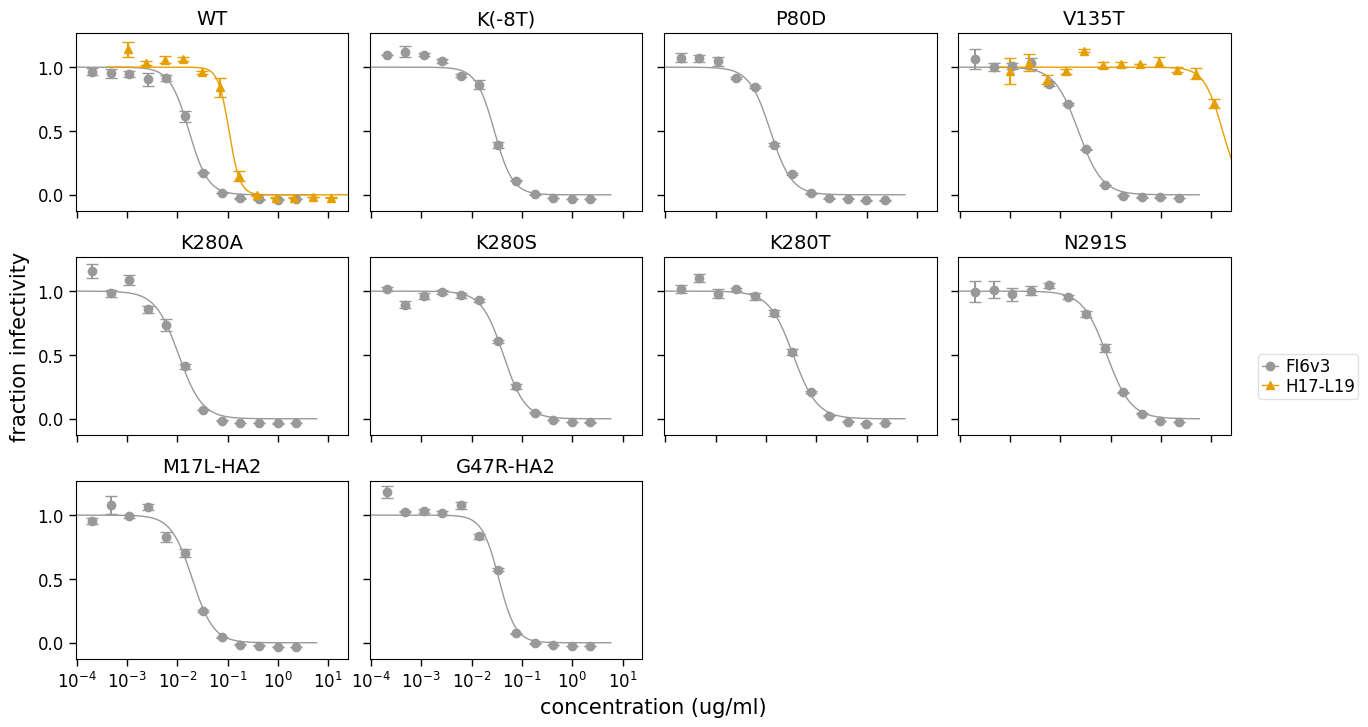

In [24]:
fig, axes = fits.plotViruses(xlabel="concentration (ug/ml)")

We can also make the plot for just certain viruses:

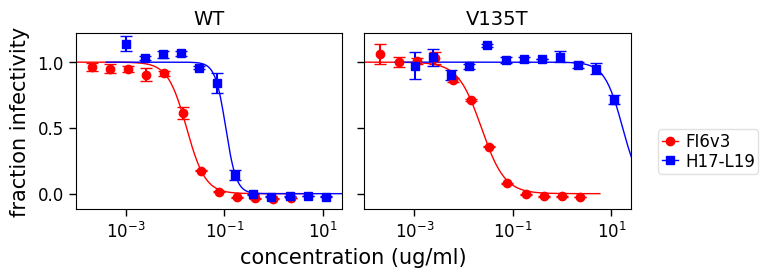

In [25]:
fig, axes = fits.plotViruses(
    xlabel="concentration (ug/ml)",
    viruses=["WT", "V135T"],
    serum_to_color_marker={"FI6v3": ("red", "o"), "H17-L19": ("blue", "s")},
)

and also for just certain sera:

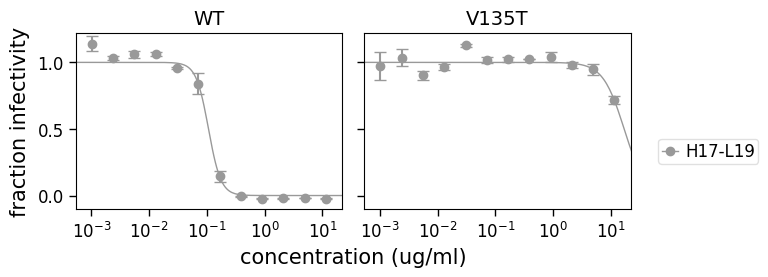

In [26]:
fig, axes = fits.plotViruses(
    xlabel="concentration (ug/ml)", viruses=["WT", "V135T"], sera=["H17-L19"]
)

### Plotting each replicate

Another type of plot that is sometimes useful is one that shows all the
replicates for each serum / virus combination. Such a plot is easily
generated using `neutcurve.curvefits.CurveFits.plotReplicates()`
as below:

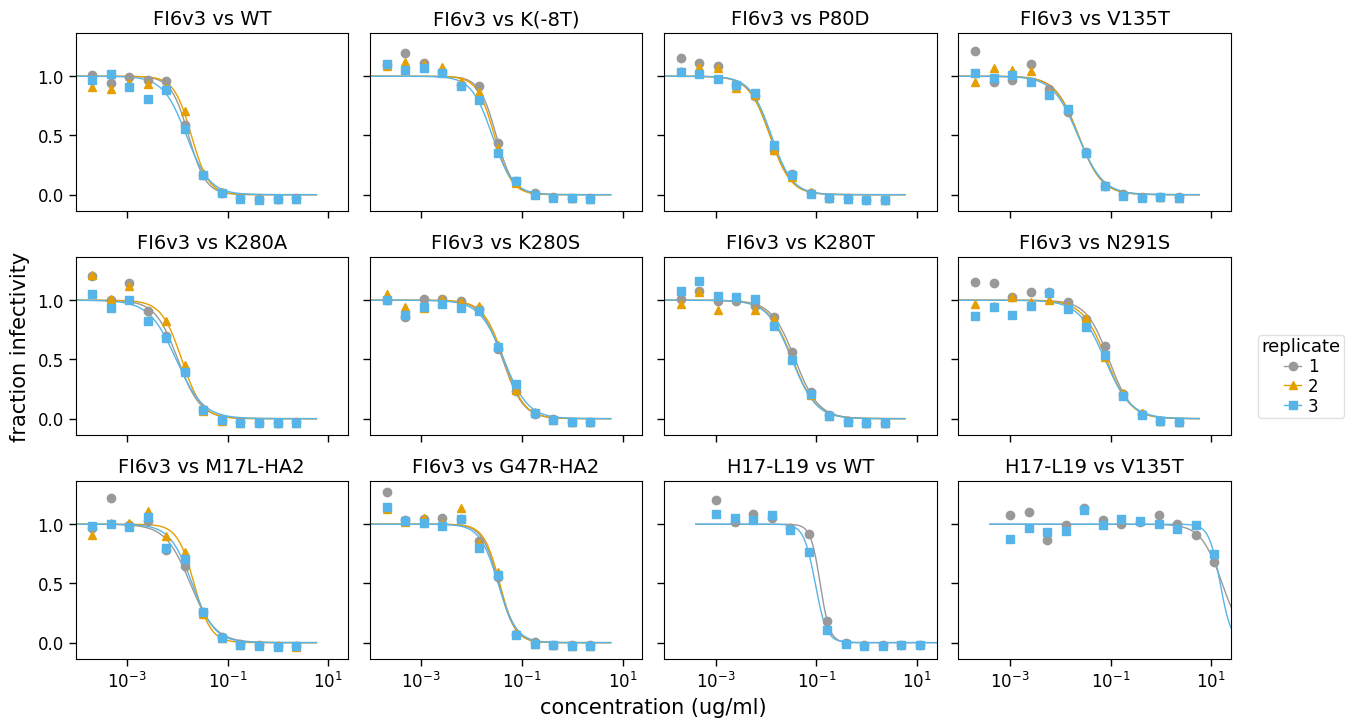

In [27]:
fig, axes = fits.plotReplicates(xlabel="concentration (ug/ml)", legendtitle="replicate")

If you do not want to share the legend across panesl, use `attempt_shared_legend=False`:

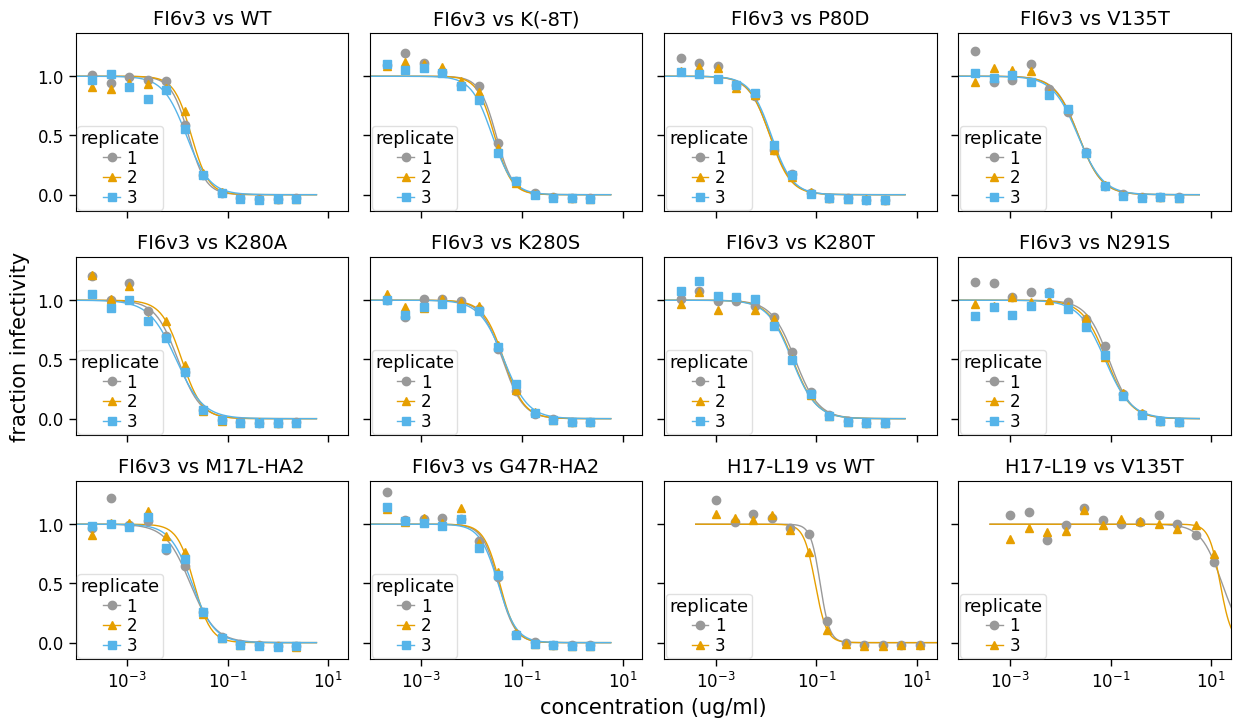

In [28]:
fig, axes = fits.plotReplicates(
    xlabel="concentration (ug/ml)",
    legendtitle="replicate",
    attempt_shared_legend=False,
)

See the method docstring for
`neutcurve.curvefits.CurveFits.plotReplicates()` for ways to
further customize these plots.

### Plotting average for each serum-virus pair

Another type of plot that is useful is one that simply shows the
replicate-average for each serum-virus pair on its own subplot. This plot can
be generated with
`neutcurve.curvefits.CurveFits.plotAverages()`:

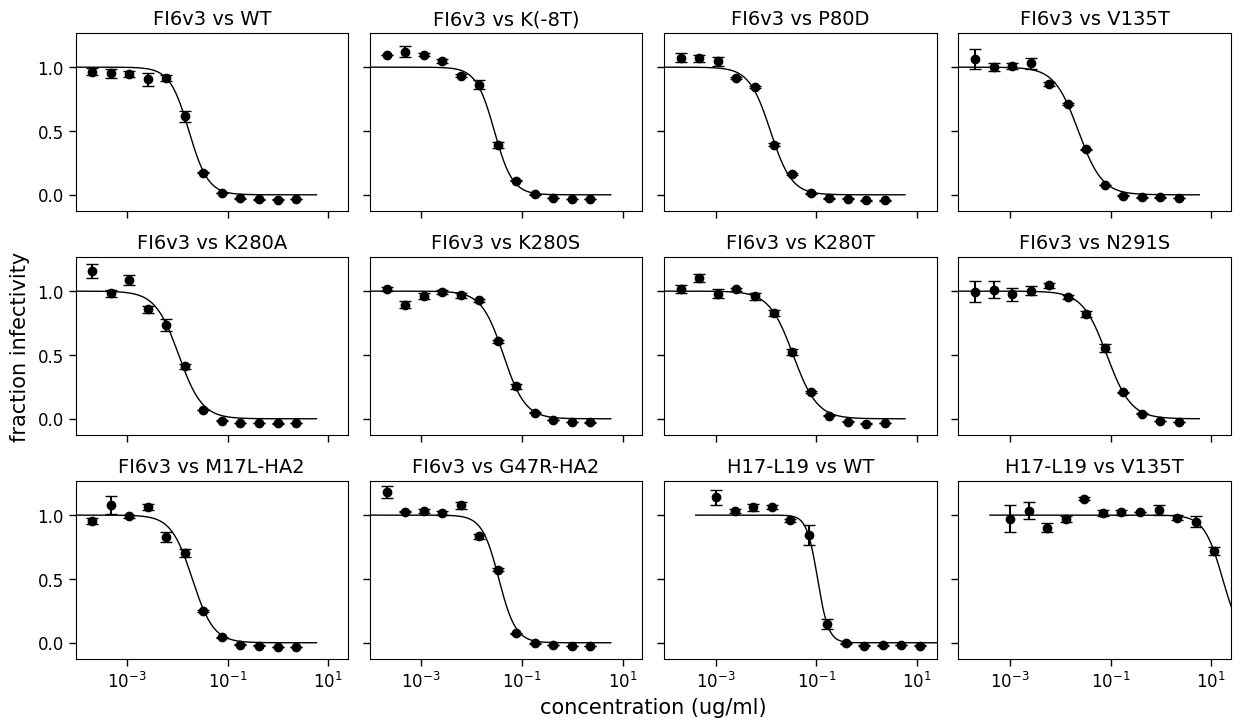

In [29]:
fig, axes = fits.plotAverages(xlabel="concentration (ug/ml)")

### Customized plot arrangements

There are obviously many other ways that it’s possible to lay out the
different curves for sera / viruses / replicates on subplots. You can
make an arbitrarily customized layout using
`neutcurve.curvefits.CurveFits.plotGrid()` where you explicitly
pass the curves to put at each subplot in the plot.

Below we illustrate how to do this to create a plot that essentially
mimics what is shown in [Fig 6a,b of Doud et al
(2018)](https://www.nature.com/articles/s41467-018-03665-3#Fig6)
(although those published plots were not generated using this program).
Note that in doing this below, we use the colors and markers defined by
 and  in `neutcurve.colorschemes`:

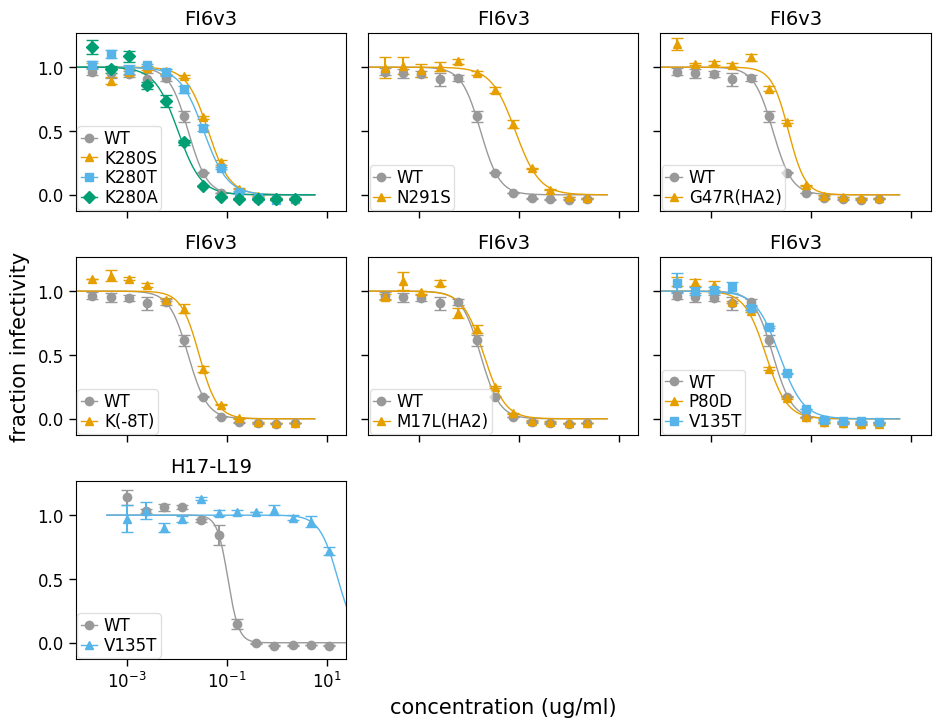

In [30]:
fig, axes = fits.plotGrid(
    {
        # upper right: FI6v3 versus WT, K280S, K280T, K280A
        (0, 0): (
            "FI6v3",
            [
                {
                    "serum": "FI6v3",
                    "virus": "WT",
                    "replicate": "average",
                    "color": CBPALETTE[0],
                    "marker": CBMARKERS[0],
                    "label": "WT",
                },
                {
                    "serum": "FI6v3",
                    "virus": "K280S",
                    "replicate": "average",
                    "color": CBPALETTE[1],
                    "marker": CBMARKERS[1],
                    "label": "K280S",
                },
                {
                    "serum": "FI6v3",
                    "virus": "K280T",
                    "replicate": "average",
                    "color": CBPALETTE[2],
                    "marker": CBMARKERS[2],
                    "label": "K280T",
                },
                {
                    "serum": "FI6v3",
                    "virus": "K280A",
                    "replicate": "average",
                    "color": CBPALETTE[3],
                    "marker": CBMARKERS[3],
                    "label": "K280A",
                },
            ],
        ),
        # upper center: FI6v3 versus WT, N291S
        (0, 1): (
            "FI6v3",
            [
                {
                    "serum": "FI6v3",
                    "virus": "WT",
                    "replicate": "average",
                    "color": CBPALETTE[0],
                    "marker": CBMARKERS[0],
                    "label": "WT",
                },
                {
                    "serum": "FI6v3",
                    "virus": "N291S",
                    "replicate": "average",
                    "color": CBPALETTE[1],
                    "marker": CBMARKERS[1],
                    "label": "N291S",
                },
            ],
        ),
        # upper right: FI6v3 versus WT, G47R-HA2
        (0, 2): (
            "FI6v3",
            [
                {
                    "serum": "FI6v3",
                    "virus": "WT",
                    "replicate": "average",
                    "color": CBPALETTE[0],
                    "marker": CBMARKERS[0],
                    "label": "WT",
                },
                {
                    "serum": "FI6v3",
                    "virus": "G47R-HA2",
                    "replicate": "average",
                    "color": CBPALETTE[1],
                    "marker": CBMARKERS[1],
                    "label": "G47R(HA2)",
                },
            ],
        ),
        # middle right: FI6v3 versus WT, K(-8T)
        (1, 0): (
            "FI6v3",
            [
                {
                    "serum": "FI6v3",
                    "virus": "WT",
                    "replicate": "average",
                    "color": CBPALETTE[0],
                    "marker": CBMARKERS[0],
                    "label": "WT",
                },
                {
                    "serum": "FI6v3",
                    "virus": "K(-8T)",
                    "replicate": "average",
                    "color": CBPALETTE[1],
                    "marker": CBMARKERS[1],
                    "label": "K(-8T)",
                },
            ],
        ),
        # middle center: FI6v3 versus WT, M17L-HA2
        (1, 1): (
            "FI6v3",
            [
                {
                    "serum": "FI6v3",
                    "virus": "WT",
                    "replicate": "average",
                    "color": CBPALETTE[0],
                    "marker": CBMARKERS[0],
                    "label": "WT",
                },
                {
                    "serum": "FI6v3",
                    "virus": "M17L-HA2",
                    "replicate": "average",
                    "color": CBPALETTE[1],
                    "marker": CBMARKERS[1],
                    "label": "M17L(HA2)",
                },
            ],
        ),
        # middle right: FI6v3 versus WT, P80D, V135T
        (1, 2): (
            "FI6v3",
            [
                {
                    "serum": "FI6v3",
                    "virus": "WT",
                    "replicate": "average",
                    "color": CBPALETTE[0],
                    "marker": CBMARKERS[0],
                    "label": "WT",
                },
                {
                    "serum": "FI6v3",
                    "virus": "P80D",
                    "replicate": "average",
                    "color": CBPALETTE[1],
                    "marker": CBMARKERS[1],
                    "label": "P80D",
                },
                {
                    "serum": "FI6v3",
                    "virus": "V135T",
                    "replicate": "average",
                    "color": CBPALETTE[2],
                    "marker": CBMARKERS[2],
                    "label": "V135T",
                },
            ],
        ),
        # middle left: H17-L19 versus WT, V135T
        (2, 0): (
            "H17-L19",
            [
                {
                    "serum": "H17-L19",
                    "virus": "WT",
                    "replicate": "average",
                    "color": CBPALETTE[0],
                    "marker": CBMARKERS[0],
                    "label": "WT",
                },
                {
                    "serum": "H17-L19",
                    "virus": "V135T",
                    "replicate": "average",
                    "color": CBPALETTE[2],
                    "marker": CBMARKERS[1],
                    "label": "V135T",
                },
            ],
        ),
    },
    xlabel="concentration (ug/ml)",
)

Fitting some problematic curves

Here we demonstrate that the method can also fit a problematic HIV curve
that never reaches the IC50.

Data frame with data for virus not neutralized at any concentration:

In [31]:
hiv_neut_data = pd.concat(
    [
        pd.DataFrame(
            {
                "serum": "BF520.1",
                "virus": "H330R",
                "replicate": 1,
                "concentration": [
                    0.020576132,
                    0.061728395,
                    0.185185185,
                    0.555555556,
                    1.666666667,
                    5,
                ],
                "fraction infectivity": [
                    0.721440083,
                    0.882537173,
                    1.01964302,
                    0.904916836,
                    0.870465533,
                    0.866026089,
                ],
            }
        ),
        pd.DataFrame(
            {
                "serum": "BF520.1",
                "virus": "H330R",
                "replicate": 2,
                "concentration": [
                    0.020576132,
                    0.061728395,
                    0.185185185,
                    0.555555556,
                    1.666666667,
                    5,
                ],
                "fraction infectivity": [
                    0.857961054,
                    0.973908617,
                    1.04569174,
                    1.007668321,
                    0.959208349,
                    1.046646303,
                ],
            }
        ),
    ]
)
hiv_neut_data.head()

,serum,virus,replicate,concentration,fraction infectivity
0,BF520.1,H330R,1,0.0206,0.721
1,BF520.1,H330R,1,0.0617,0.883
2,BF520.1,H330R,1,0.185,1.02
3,BF520.1,H330R,1,0.556,0.905
4,BF520.1,H330R,1,1.67,0.87


Fit and plot curve:

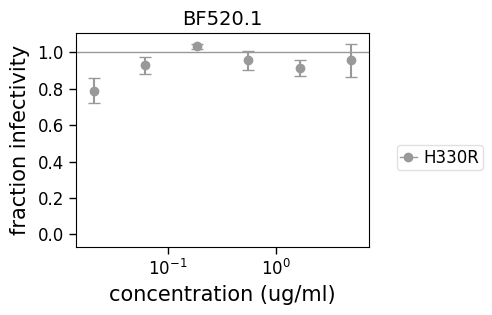

In [32]:
hiv_fit = neutcurve.CurveFits(hiv_neut_data)
_ = hiv_fit.plotSera(xlabel="concentration (ug/ml)")

In [33]:
hiv_fit.fitParams()

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2
0,BF520.1,H330R,average,2,5,lower,>5,543,5,lower,13,1,0,-0.932


### Drawing vertical lines

It can sometimes be useful to draw vertical lines on the plot, such as to
indicate concentrations used for selection experiments. This can be done in
a highly customized way using the  option to
`neutcurve.curvefits.CurveFits.plotSera()` as in the example below:

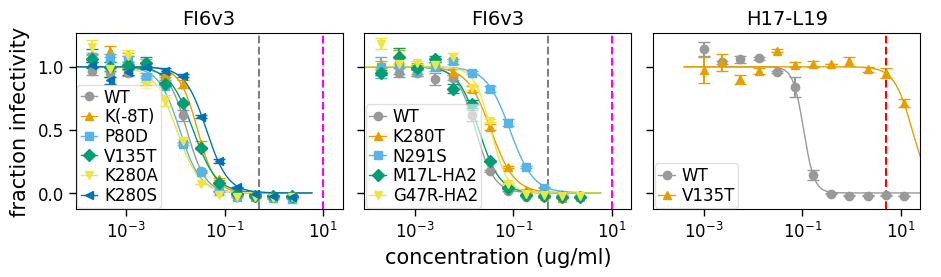

In [34]:
fig, axes = fits.plotSera(
    max_viruses_per_subplot=6,
    nrow=1,
    ncol=None,
    xlabel="concentration (ug/ml)",
    vlines={
        "FI6v3": [{"x": 0.5}, {"x": 10, "color": "magenta"}],
        "H17-L19": [{"x": 5, "linestyle": "--", "color": "red"}],
    },
)

### Additional plot customization

The plots are returned as  figures / axes, so can be customized
just like any other  generated plot. For instance, to customize
axis ticks and labels, you can do the below:

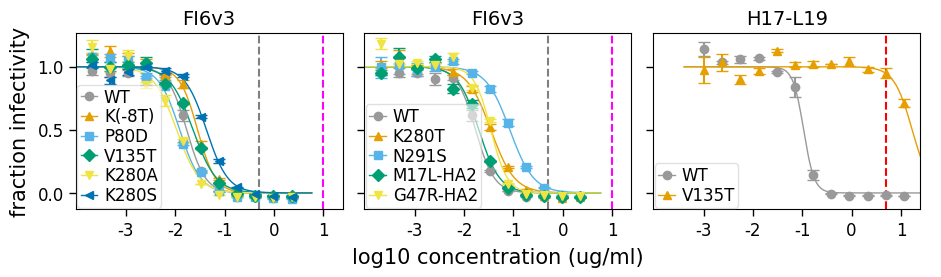

In [35]:
fig2, axes2 = fits.plotSera(
    max_viruses_per_subplot=6,
    nrow=1,
    ncol=None,
    xlabel="log10 concentration (ug/ml)",
    vlines={
        "FI6v3": [{"x": 0.5}, {"x": 10, "color": "magenta"}],
        "H17-L19": [{"x": 5, "linestyle": "--", "color": "red"}],
    },
)
_ = axes2.ravel()[-1].set_xticks([1e-3, 1e-2, 1e-1, 1, 10])
_ = axes2.ravel()[-1].set_xticklabels(["-3", "-2", "-1", "0", "1"])

This assumes the plotting was done using `sharex=True` and `sharey=True` (on by default), which
makes all axes share the same x-ticks so they can be set for just the last
plot. Otherwise you need to set the ticks for each axis separately.